# 1. Import *Library*

In [74]:
!pip install optuna

In [75]:
!pip install catboost

In [122]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os
import optuna

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, auc

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 2. Memuat Dataset

In [77]:
path = kagglehub.dataset_download("manishkc06/startup-success-prediction")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/startup-success-prediction


In [78]:
print(os.listdir(path))

['startup data.csv']


In [79]:
df = pd.read_csv(os.path.join(path, 'startup data.csv'))

# 3. Exploratory Data Analysis (EDA)

In [80]:
df.head()

,Unnamed: 0,state_code,latitude,longitude,zip_code,id,city,Unnamed: 6,name,labels,...,object_id,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500,status
0,1005,CA,42.358880,-71.056820,92101,c:6669,San Diego,NaN,Bandsintown,1,...,c:6669,0,1,0,0,0,0,1.0000,0,acquired
1,204,CA,37.238916,-121.973718,95032,c:16283,Los Gatos,NaN,TriCipher,1,...,c:16283,1,0,0,1,1,1,4.7500,1,acquired
2,1001,CA,32.901049,-117.192656,92121,c:65620,San Diego,San Diego CA 92121,Plixi,1,...,c:65620,0,0,1,0,0,0,4.0000,1,acquired
3,738,CA,37.320309,-122.050040,95014,c:42668,Cupertino,Cupertino CA 95014,Solidcore Systems,1,...,c:42668,0,0,0,1,1,1,3.3333,1,acquired
4,1002,CA,37.779281,-122.419236,94105,c:65806,San Francisco,San Francisco CA 94105,Inhale Digital,0,...,c:65806,1,1,0,0,0,0,1.0000,1,closed


In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 49 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                923 non-null    int64  
 1   state_code                923 non-null    object 
 2   latitude                  923 non-null    float64
 3   longitude                 923 non-null    float64
 4   zip_code                  923 non-null    object 
 5   id                        923 non-null    object 
 6   city                      923 non-null    object 
 7   Unnamed: 6                430 non-null    object 
 8   name                      923 non-null    object 
 9   labels                    923 non-null    int64  
 10  founded_at                923 non-null    object 
 11  closed_at                 335 non-null    object 
 12  first_funding_at          923 non-null    object 
 13  last_funding_at           923 non-null    object 
 14  age_first_

In [82]:
df.describe()

,Unnamed: 0,latitude,longitude,labels,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,is_top500
count,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,771.000000,771.000000,923.000000,923.000000,...,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000,923.000000
mean,572.297941,38.517442,-103.539212,0.646804,2.235630,3.931456,3.055353,4.754423,7.710726,2.310943,...,0.003250,0.322860,0.326111,0.254605,0.508126,0.392199,0.232936,0.099675,2.838586,0.809317
std,333.585431,3.741497,22.394167,0.478222,2.510449,2.967910,2.977057,3.212107,7.265776,1.390922,...,0.056949,0.467823,0.469042,0.435875,0.500205,0.488505,0.422931,0.299729,1.874601,0.393052
min,1.000000,25.752358,-122.756956,0.000000,-9.046600,-9.046600,-14.169900,-7.005500,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,283.500000,37.388869,-122.198732,0.000000,0.576700,1.669850,1.000000,2.411000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000,1.000000
50%,577.000000,37.779281,-118.374037,1.000000,1.446600,3.528800,2.520500,4.476700,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.500000,1.000000
75%,866.500000,40.730646,-77.214731,1.000000,3.575350,5.560250,4.686300,6.753400,10.000000,3.000000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,3.800000,1.000000
max,1153.000000,59.335232,18.057121,1.000000,21.895900,21.895900,24.684900,24.684900,63.000000,10.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000,1.000000


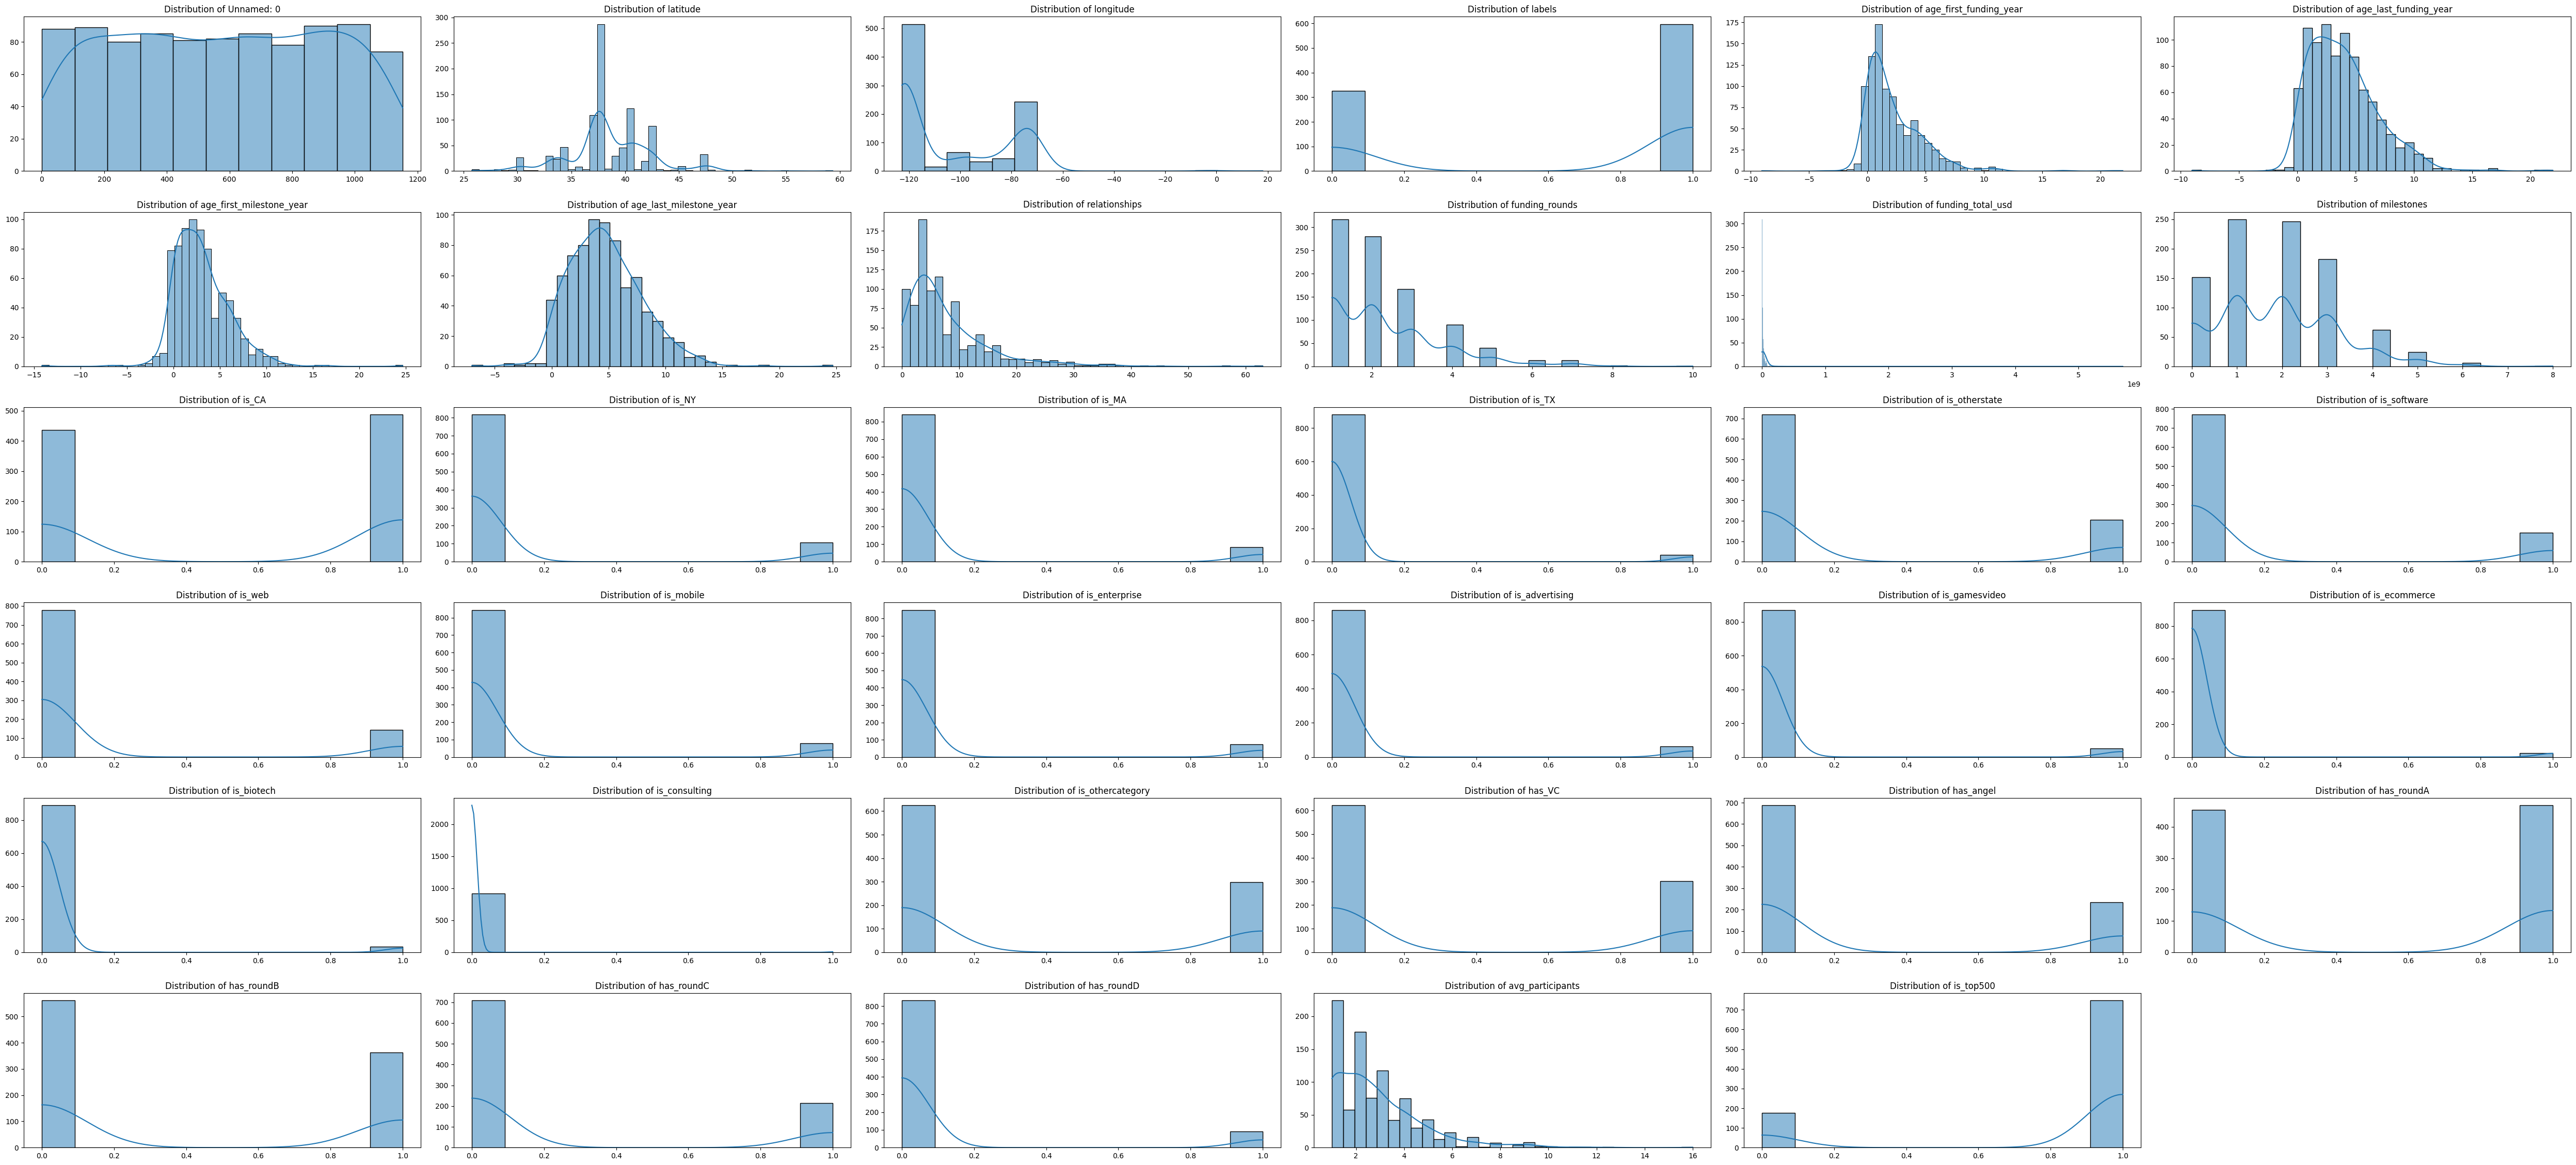

In [83]:
num_cols = df.select_dtypes(include=['number']).columns
n = len(num_cols)

fig, axs = plt.subplots(8, 6, figsize=(50, 30))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribution of {col}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(len(num_cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

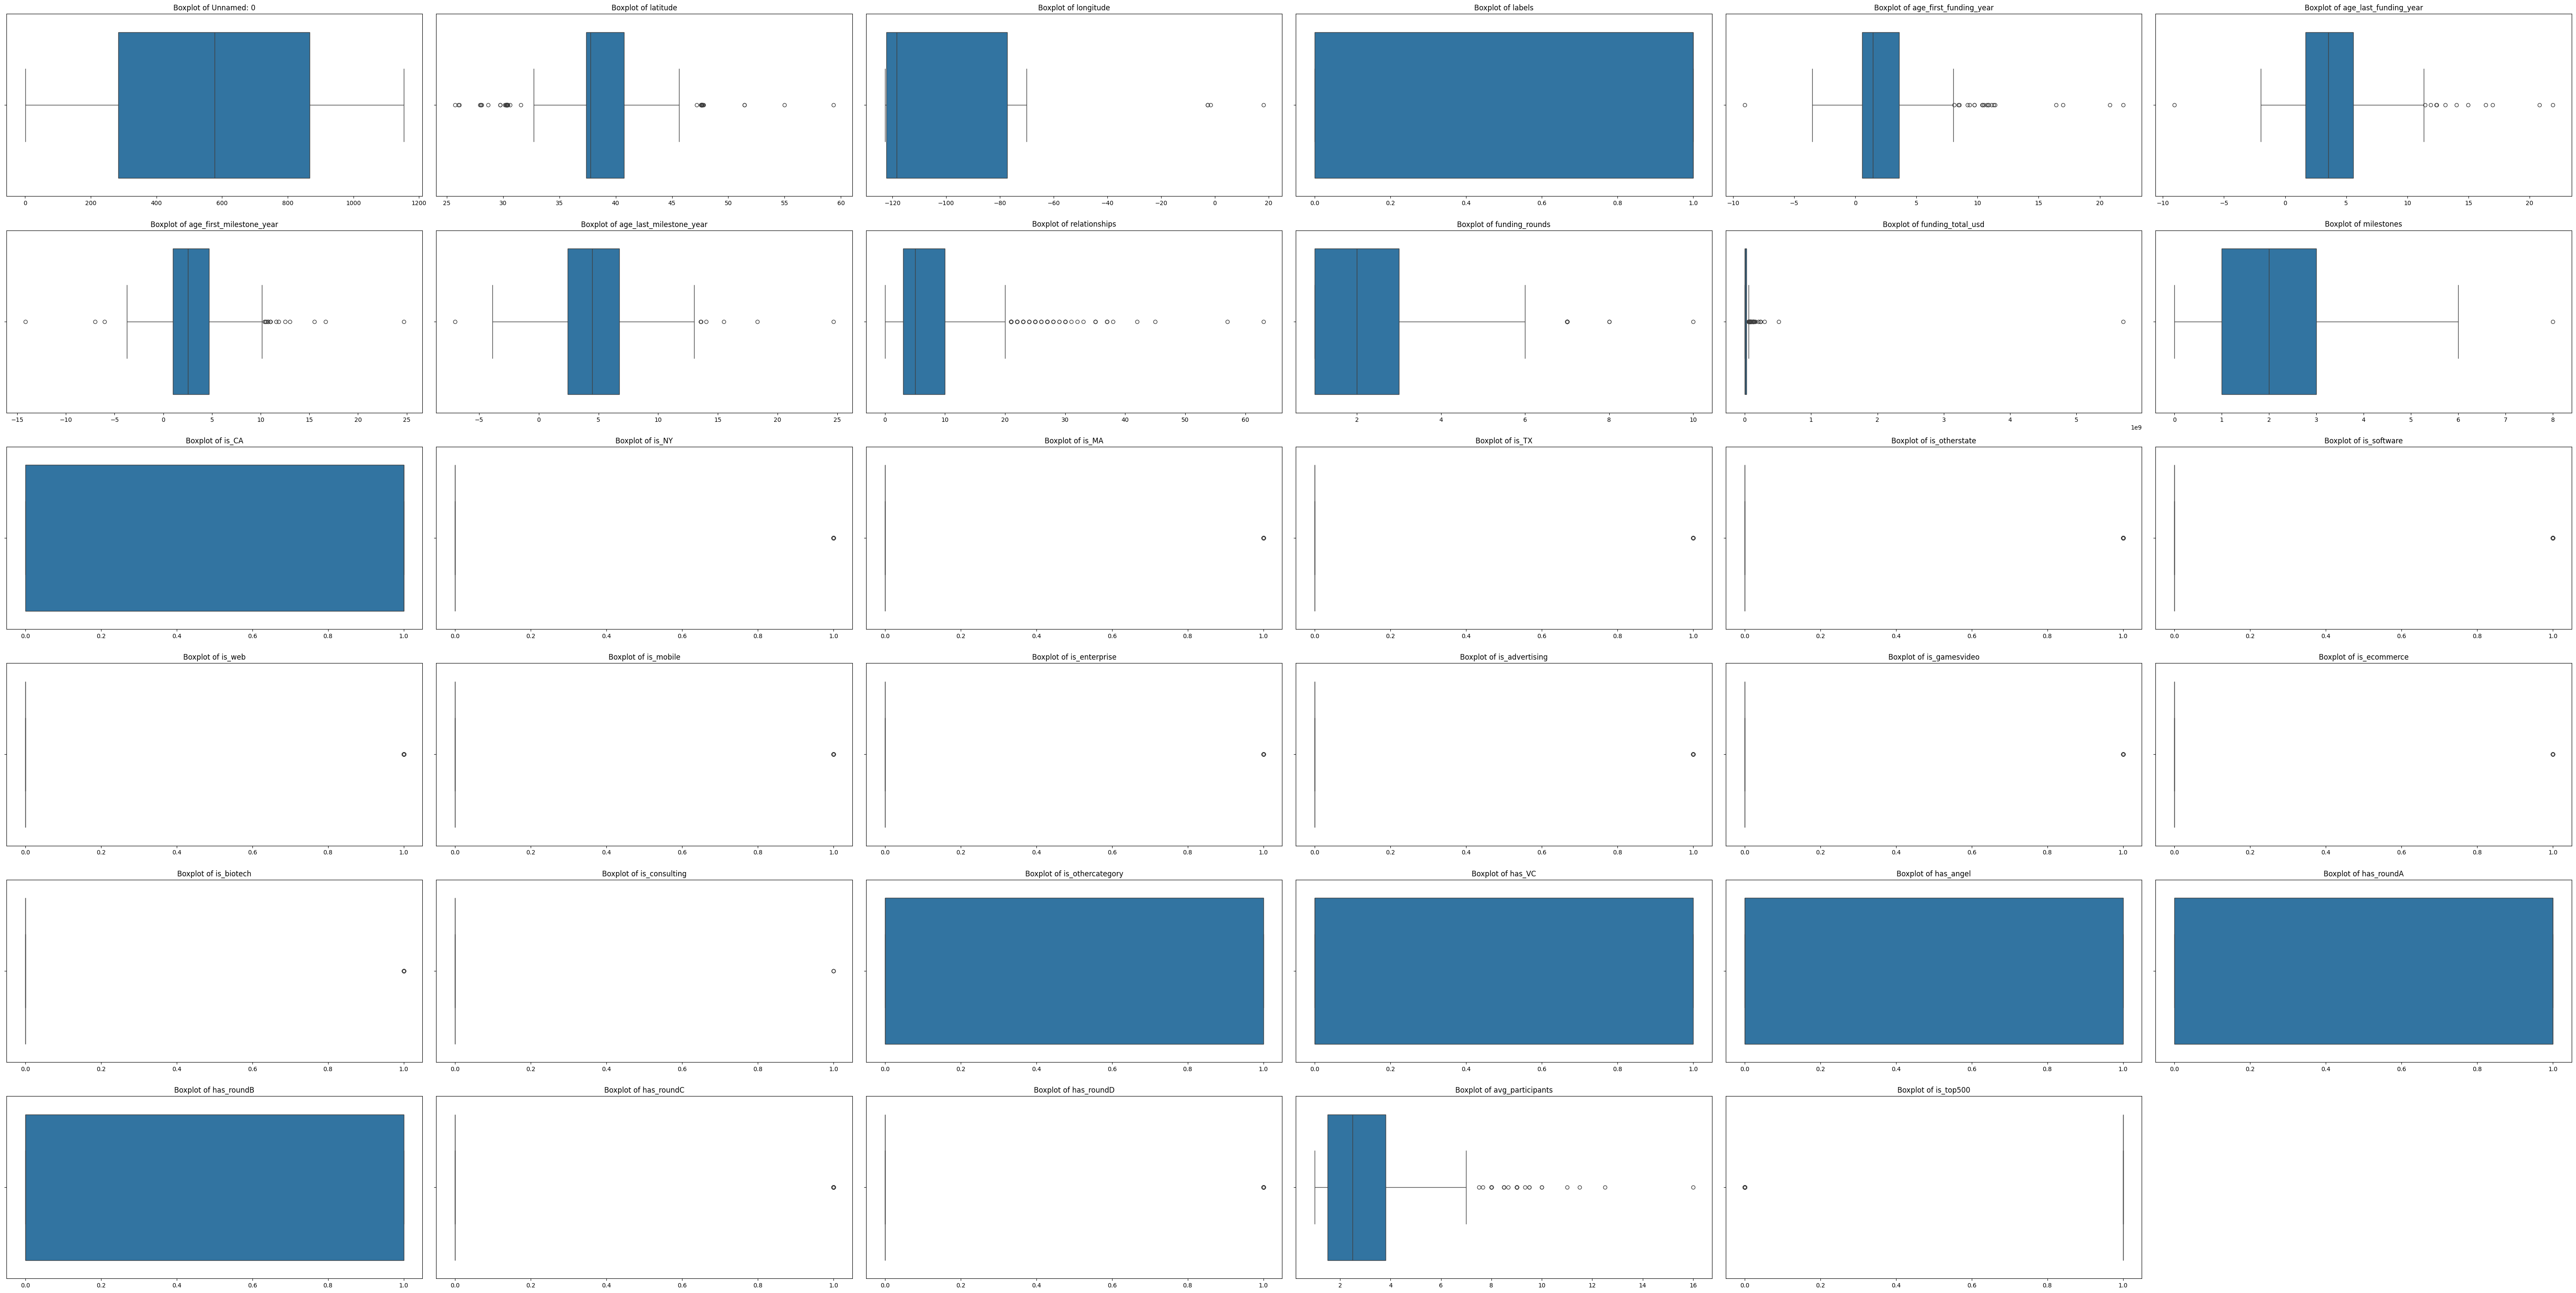

In [84]:
fig, axs = plt.subplots(8, 6, figsize=(60, 40))
axs = axs.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Boxplot of {col}')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

for j in range(len(num_cols), len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# 4. Pembersihan Dataset

In [85]:
df.isnull().sum()

,0
Unnamed: 0,0
state_code,0
latitude,0
longitude,0
zip_code,0
id,0
city,0
Unnamed: 6,493
name,0
labels,0


In [86]:
df.duplicated().sum()

np.int64(0)

In [87]:
df['status'].value_counts()

,count
status,
acquired,597
closed,326


In [88]:
# Drop kolom tidak perlu
df.drop(['Unnamed: 0', 'state_code', 'latitude' ,
        'longitude', 'zip_code', 'id', 'Unnamed: 6',
        'labels', 'name', 'founded_at', 'closed_at',
        'state_code.1', 'category_code', 'object_id', 'city'], axis=1, inplace=True)

In [89]:
df.isnull().sum()

,0
first_funding_at,0
last_funding_at,0
age_first_funding_year,0
age_last_funding_year,0
age_first_milestone_year,152
age_last_milestone_year,152
relationships,0
funding_rounds,0
funding_total_usd,0
milestones,0


In [90]:
# Fill NA menjadi 0 karena startup belum mencapai milestone
df.fillna(0, inplace=True)

In [91]:
# Menambah kolom span funding (tahun)
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
df['funding_age_span_days'] = (df['last_funding_at'] - df['first_funding_at']).dt.days
df['funding_age_span_years'] = df['funding_age_span_days'] / 365

# Drop kolom date
df.drop(['first_funding_at', 'last_funding_at', 'funding_age_span_days'], axis=1, inplace=True)

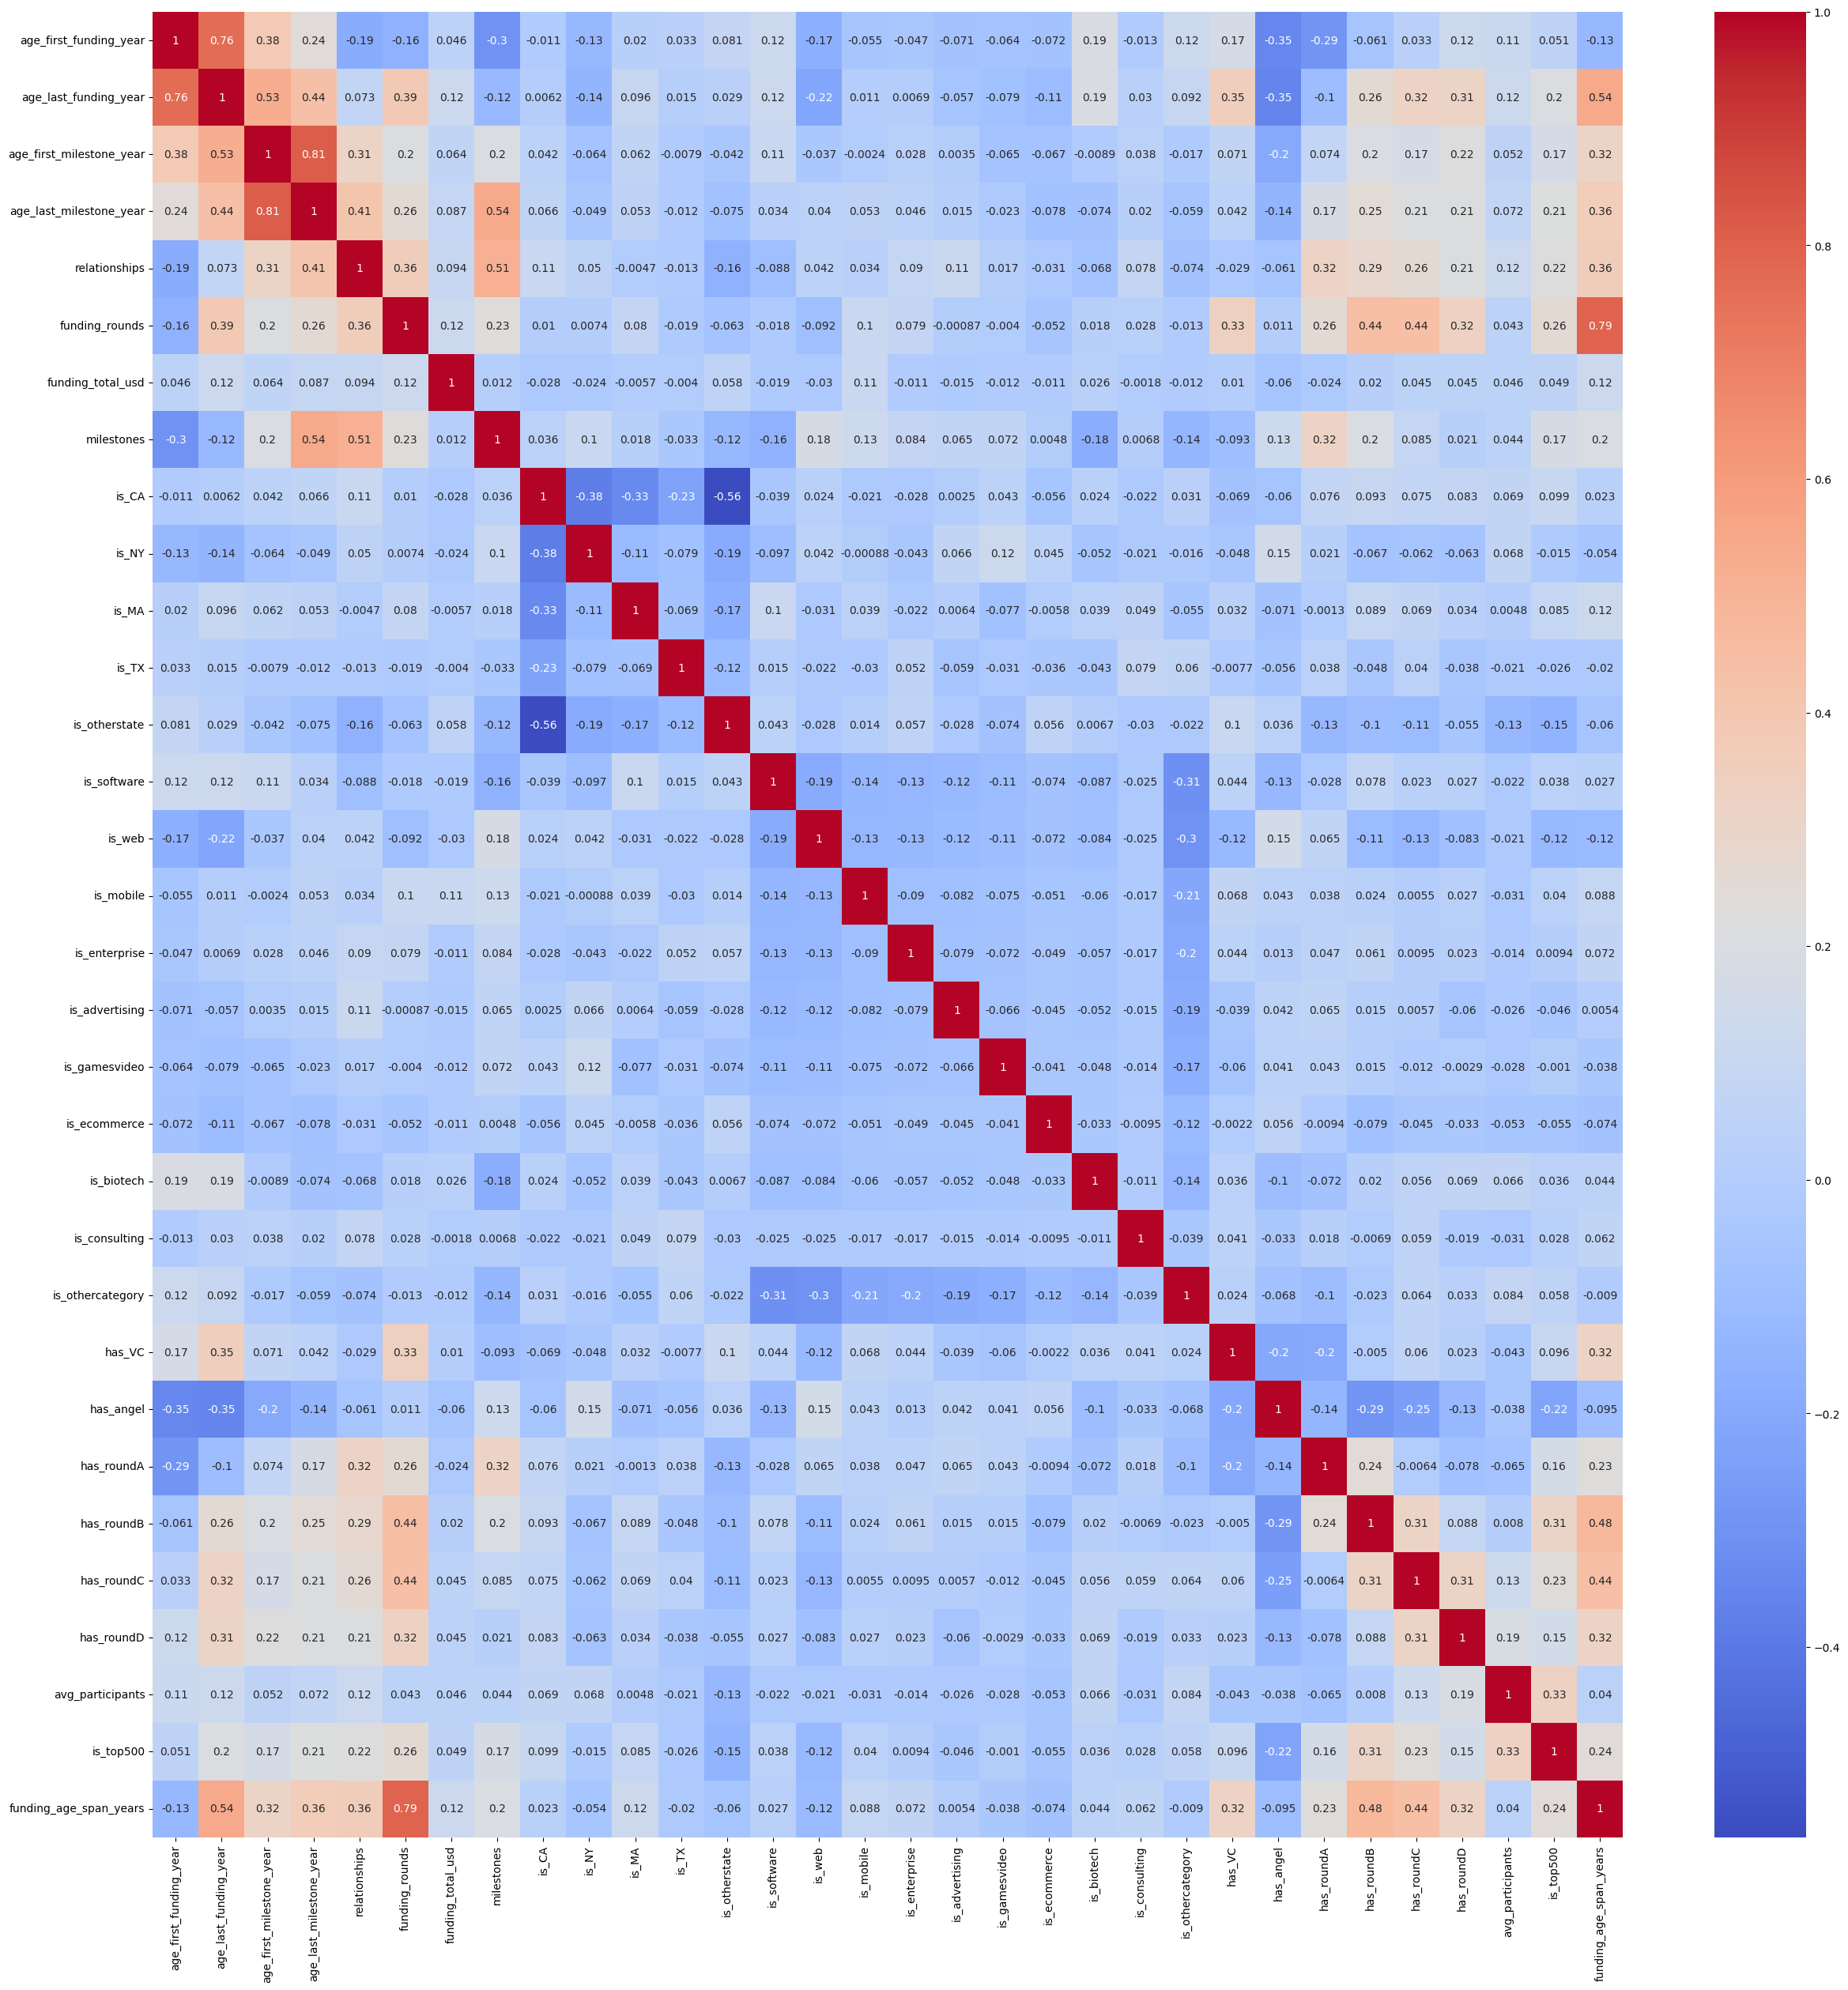

In [93]:
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(30, 30))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 923 entries, 0 to 922
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age_first_funding_year    923 non-null    float64
 1   age_last_funding_year     923 non-null    float64
 2   age_first_milestone_year  923 non-null    float64
 3   age_last_milestone_year   923 non-null    float64
 4   relationships             923 non-null    int64  
 5   funding_rounds            923 non-null    int64  
 6   funding_total_usd         923 non-null    int64  
 7   milestones                923 non-null    int64  
 8   is_CA                     923 non-null    int64  
 9   is_NY                     923 non-null    int64  
 10  is_MA                     923 non-null    int64  
 11  is_TX                     923 non-null    int64  
 12  is_otherstate             923 non-null    int64  
 13  is_software               923 non-null    int64  
 14  is_web    

# 5. Data Preprocessing

In [95]:
X = df.drop('status', axis=1)
y = df['status']

In [96]:
scaler = StandardScaler()
num_cols = ['age_first_funding_year', 'age_last_funding_year',
             'age_first_milestone_year', 'age_last_milestone_year',
             'relationships', 'funding_rounds', 'funding_total_usd',
             'milestones', 'avg_participants', 'funding_age_span_years']
X_scaled = X.copy()

X_scaled[num_cols] = scaler.fit_transform(X_scaled[num_cols])

In [97]:
le = LabelEncoder()
y = le.fit_transform(y)

In [98]:
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.15, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, shuffle=False)

# 6. Model 1 (CatBoost, XGBoost, MLP)

In [106]:
def objective_1(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 20),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample', 0.5, 1.0),
        'random_state': 42,
        'eval_metric': 'auc',
        'scale_pos_weight': len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))
    }

    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 400),
        'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 0
    }

    mlp_params = {
        'hidden_layer_sizes': (
            trial.suggest_int('mlp_layer1', 32, 128),
            trial.suggest_int('mlp_layer2', 32, 128)
        ),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': 1e-3,
        'learning_rate': 'adaptive',
        'max_iter': 500,
        'random_state': 42
    }

    xgb_best = XGBClassifier(**xgb_params)
    cat_best = CatBoostClassifier(**cat_params)
    meta_best = MLPClassifier(**mlp_params)

    stacking_model = StackingClassifier(
        estimators=[
            ('cat', cat_best),
            ('xgb', xgb_best)
        ],
        final_estimator=meta_best,
        cv=5,
        n_jobs=1
    )

    stacking_model.fit(X_train, y_train)
    y_val_pred_prob = stacking_model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)

    return auc_score

In [107]:
study_1 = optuna.create_study(direction='maximize')
study_1.optimize(objective_1, n_trials=100)

print("Best params:", study_1.best_params)
print("Best AUC score:", study_1.best_value)

[I 2025-07-01 03:00:55,229] A new study created in memory with name: no-name-99eb9283-7a64-45c1-a030-a75a15ca84ca
[I 2025-07-01 03:01:00,735] Trial 0 finished with value: 0.8275559455901711 and parameters: {'xgb_n_estimators': 160, 'xgb_max_depth': 14, 'xgb_learning_rate': 0.050453924032009066, 'xgb_subsample': 0.850487048568594, 'xgb_colsample': 0.7169654884346524, 'cat_iterations': 148, 'cat_learning_rate': 0.16414305207467622, 'cat_depth': 4, 'mlp_layer1': 119, 'mlp_layer2': 105}. Best is trial 0 with value: 0.8275559455901711.
[I 2025-07-01 03:01:06,364] Trial 1 finished with value: 0.8273365511189118 and parameters: {'xgb_n_estimators': 243, 'xgb_max_depth': 16, 'xgb_learning_rate': 0.15717441751535566, 'xgb_subsample': 0.7121123390696222, 'xgb_colsample': 0.7752039869610754, 'cat_iterations': 245, 'cat_learning_rate': 0.09336523177389194, 'cat_depth': 6, 'mlp_layer1': 80, 'mlp_layer2': 83}. Best is trial 0 with value: 0.8275559455901711.
[I 2025-07-01 03:01:11,676] Trial 2 finish

Best params: {'xgb_n_estimators': 287, 'xgb_max_depth': 8, 'xgb_learning_rate': 0.26521498325973714, 'xgb_subsample': 0.5404433012569999, 'xgb_colsample': 0.9946438975289088, 'cat_iterations': 255, 'cat_learning_rate': 0.024223386139912505, 'cat_depth': 4, 'mlp_layer1': 32, 'mlp_layer2': 104}
Best AUC score: 0.8740675734971478


In [108]:
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

best_params_1 = study_1.best_params

cat_best_1 = CatBoostClassifier(
    iterations=best_params_1['cat_iterations'],
    learning_rate=best_params_1['cat_learning_rate'],
    depth=best_params_1['cat_depth'],
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

xgb_best_1 = XGBClassifier(
    n_estimators=best_params_1['xgb_n_estimators'],
    max_depth=best_params_1['xgb_max_depth'],
    learning_rate=best_params_1['xgb_learning_rate'],
    subsample=best_params_1['xgb_subsample'],
    colsample_bytree=best_params_1['xgb_colsample'],
    random_state=42,
    eval_metric='auc',
    scale_pos_weight=ratio
)

meta_best_1 = MLPClassifier(
    hidden_layer_sizes=(best_params_1['mlp_layer1'], best_params_1['mlp_layer2']),
    activation='relu',
    solver='adam',
    alpha=1e-3,
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

stacking_model_1 = StackingClassifier(
    estimators=[('cat', cat_best_1), ('xgb', xgb_best_1)],
    final_estimator=meta_best_1,
    cv=5,
    n_jobs=1
)

stacking_model_1.fit(X_train, y_train)

y_val_pred_1 = stacking_model_1.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_1))
print("Validation Report:\n", classification_report(y_val, y_val_pred_1))

y_test_pred_1 = stacking_model_1.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_1))
print("Test Report:\n", classification_report(y_test, y_test_pred_1))

Validation Accuracy: 0.8129496402877698
Validation Report:
               precision    recall  f1-score   support

           0       0.80      0.93      0.86        86
           1       0.85      0.62      0.72        53

    accuracy                           0.81       139
   macro avg       0.82      0.78      0.79       139
weighted avg       0.82      0.81      0.81       139

Test Accuracy: 0.7913669064748201
Test Report:
               precision    recall  f1-score   support

           0       0.81      0.91      0.86        97
           1       0.71      0.52      0.60        42

    accuracy                           0.79       139
   macro avg       0.76      0.72      0.73       139
weighted avg       0.78      0.79      0.78       139



In [109]:
print("F1 Score:", f1_score(y_test, y_test_pred_1))
print("ROC AUC Score:", roc_auc_score(y_test, stacking_model_1.predict_proba(X_test)[:, 1]))

F1 Score: 0.6027397260273972
ROC AUC Score: 0.8505154639175257


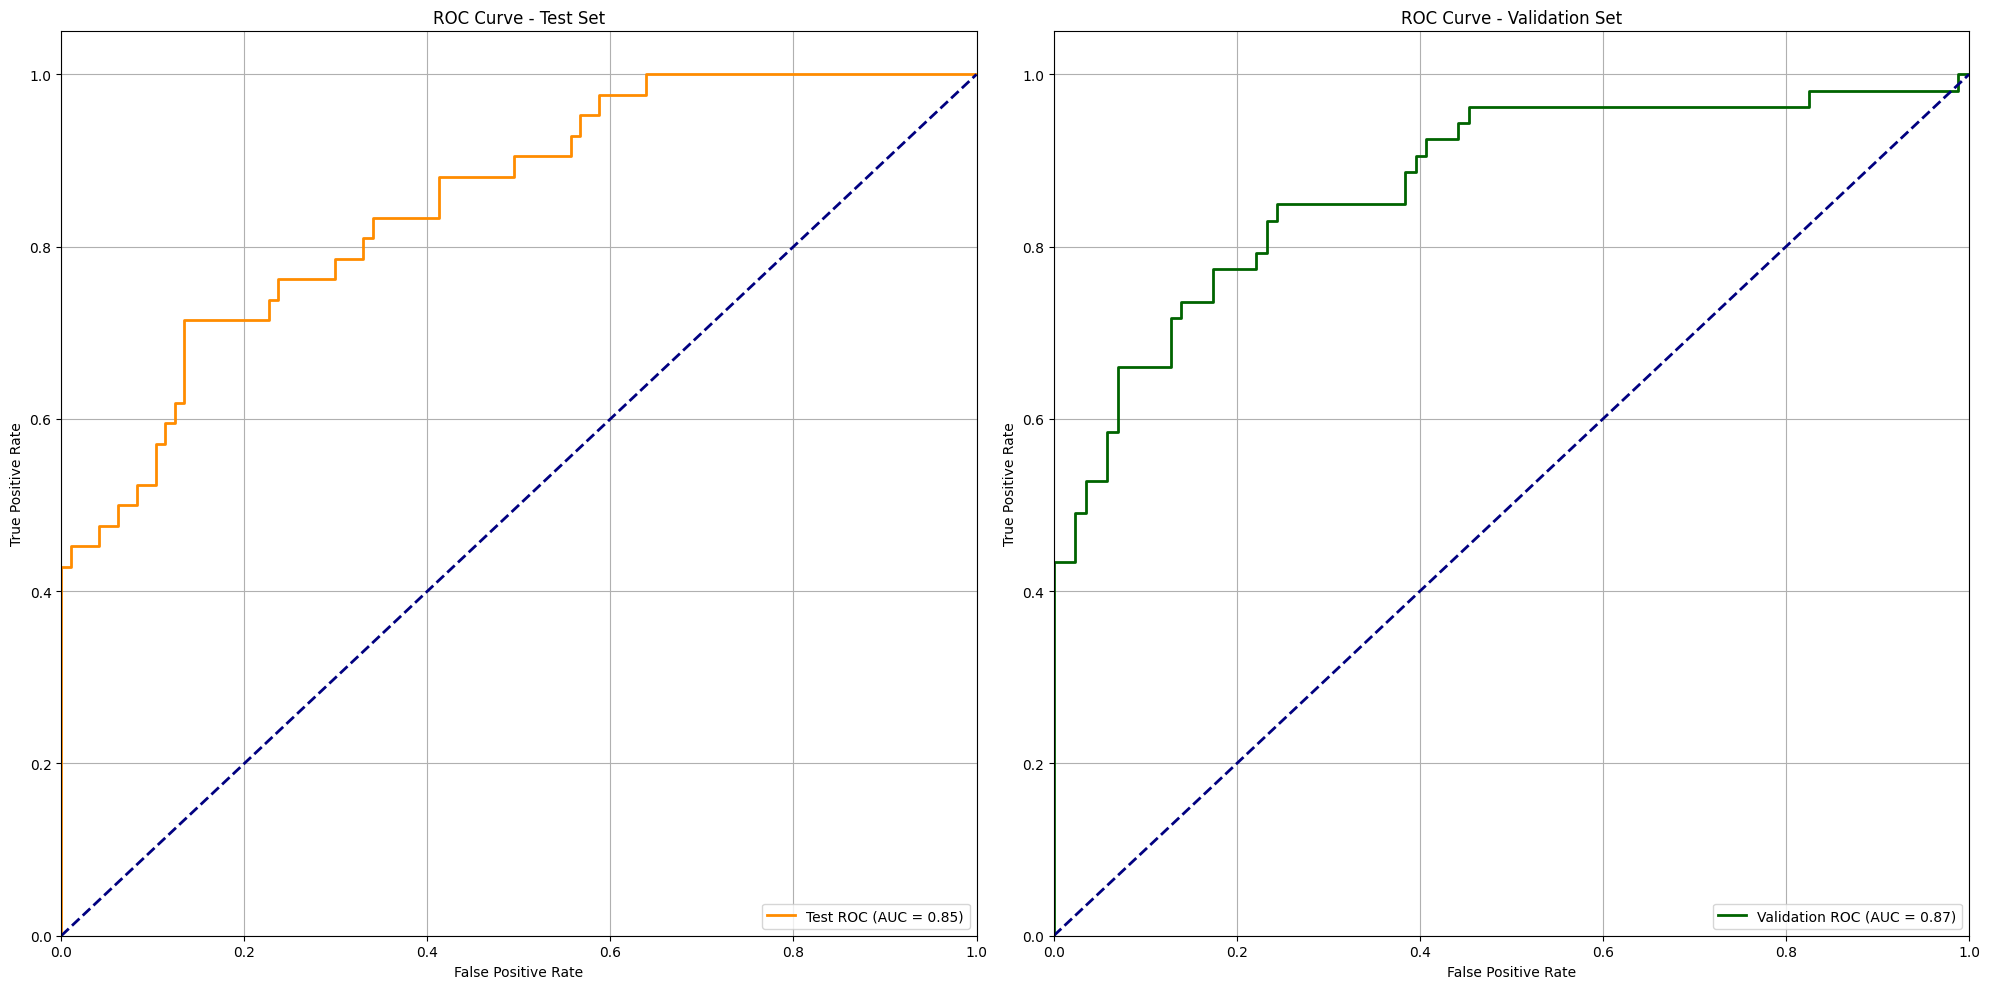

In [126]:
fpr_test, tpr_test, _ = roc_curve(y_test, stacking_model_1.predict_proba(X_test)[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

fpr_val, tpr_val, _ = roc_curve(y_val, stacking_model_1.predict_proba(X_val)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve - Test Set')
axs[0].legend(loc='lower right')
axs[0].grid(True)

axs[1].plot(fpr_val, tpr_val, color='darkgreen', lw=2, label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve - Validation Set')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

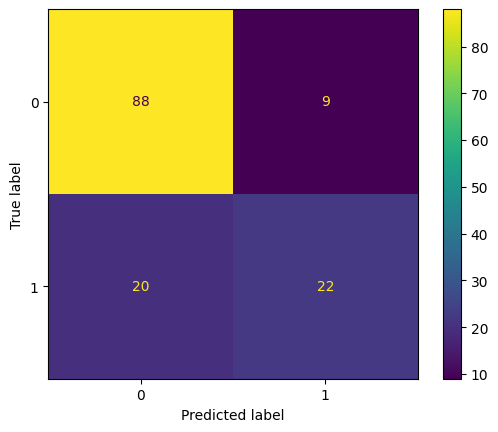

In [110]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# 7. Model 2 (CatBoost, XGBoost, RandomForest)

In [111]:
def objective_2(trial):
    xgb_params = {
        'n_estimators': trial.suggest_int('xgb_n_estimators', 50, 300),
        'max_depth': trial.suggest_int('xgb_max_depth', 3, 20),
        'learning_rate': trial.suggest_float('xgb_learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('xgb_subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('xgb_colsample', 0.5, 1.0),
        'random_state': 42,
        'eval_metric': 'auc',
        'scale_pos_weight': len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))
    }

    cat_params = {
        'iterations': trial.suggest_int('cat_iterations', 100, 400),
        'learning_rate': trial.suggest_float('cat_learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('cat_depth', 4, 10),
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': 42,
        'verbose': 0
    }

    rf_meta_params = {
        'n_estimators': trial.suggest_int('meta_n_estimators', 50, 200),
        'max_depth': trial.suggest_int('meta_max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('meta_min_samples_split', 2, 10),
        'class_weight': 'balanced',
        'random_state': 42
    }

    xgb_best = XGBClassifier(**xgb_params)
    cat_best = CatBoostClassifier(**cat_params)
    meta_best = RandomForestClassifier(**rf_meta_params)

    stacking_model = StackingClassifier(
        estimators=[
            ('cat', cat_best),
            ('xgb', xgb_best)
        ],
        final_estimator=meta_best,
        cv=5,
        n_jobs=1
    )

    stacking_model.fit(X_train, y_train)
    y_val_pred_prob = stacking_model.predict_proba(X_val)[:, 1]
    auc_score = roc_auc_score(y_val, y_val_pred_prob)

    return auc_score

In [112]:
study_2 = optuna.create_study(direction='maximize')
study_2.optimize(objective_2, n_trials=100)

print("Best params:", study_2.best_params)
print("Best AUC score:", study_2.best_value)

[I 2025-07-01 03:13:40,432] A new study created in memory with name: no-name-5a055baa-79f0-4068-b891-7c24cbe5c694
[I 2025-07-01 03:14:22,401] Trial 0 finished with value: 0.8017770952172004 and parameters: {'xgb_n_estimators': 64, 'xgb_max_depth': 15, 'xgb_learning_rate': 0.18118898845314774, 'xgb_subsample': 0.5459453984265337, 'xgb_colsample': 0.8830541499295006, 'cat_iterations': 276, 'cat_learning_rate': 0.267625820728804, 'cat_depth': 10, 'meta_n_estimators': 109, 'meta_max_depth': 13, 'meta_min_samples_split': 7}. Best is trial 0 with value: 0.8017770952172004.
[I 2025-07-01 03:14:33,122] Trial 1 finished with value: 0.8245941202281702 and parameters: {'xgb_n_estimators': 143, 'xgb_max_depth': 15, 'xgb_learning_rate': 0.05981233798531333, 'xgb_subsample': 0.8194578097814984, 'xgb_colsample': 0.862496353802354, 'cat_iterations': 300, 'cat_learning_rate': 0.028043609924650305, 'cat_depth': 7, 'meta_n_estimators': 161, 'meta_max_depth': 4, 'meta_min_samples_split': 2}. Best is trial

Best params: {'xgb_n_estimators': 200, 'xgb_max_depth': 5, 'xgb_learning_rate': 0.29631295887798614, 'xgb_subsample': 0.6631379902729717, 'xgb_colsample': 0.610884550595405, 'cat_iterations': 398, 'cat_learning_rate': 0.22852613301962094, 'cat_depth': 10, 'meta_n_estimators': 82, 'meta_max_depth': 6, 'meta_min_samples_split': 5}
Best AUC score: 0.863975427819219


In [113]:
ratio = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
best_params_2 = study_2.best_params

cat_best_2 = CatBoostClassifier(
    iterations=best_params_2['cat_iterations'],
    learning_rate=best_params_2['cat_learning_rate'],
    depth=best_params_2['cat_depth'],
    loss_function='Logloss',
    eval_metric='AUC',
    random_seed=42,
    verbose=0
)

xgb_best_2 = XGBClassifier(
    n_estimators=best_params_2['xgb_n_estimators'],
    max_depth=best_params_2['xgb_max_depth'],
    learning_rate=best_params_2['xgb_learning_rate'],
    subsample=best_params_2['xgb_subsample'],
    colsample_bytree=best_params_2['xgb_colsample'],
    random_state=42,
    eval_metric='auc',
    scale_pos_weight=ratio
)

meta_best_2 = RandomForestClassifier(
    n_estimators=best_params_2['meta_n_estimators'],
    max_depth=best_params_2['meta_max_depth'],
    min_samples_split=best_params_2['meta_min_samples_split'],
    class_weight='balanced',
    random_state=42
)

stacking_model_2 = StackingClassifier(
    estimators=[('cat', cat_best_2), ('xgb', xgb_best_2)],
    final_estimator=meta_best_2,
    cv=5,
    n_jobs=1
)

stacking_model_2.fit(X_train, y_train)

y_val_pred_2 = stacking_model_2.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred_2))
print("Validation Report:\n", classification_report(y_val, y_val_pred_2))

y_test_pred_2 = stacking_model_2.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred_2))
print("Test Report:\n", classification_report(y_test, y_test_pred_2))

Validation Accuracy: 0.8345323741007195
Validation Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87        86
           1       0.84      0.70      0.76        53

    accuracy                           0.83       139
   macro avg       0.84      0.81      0.82       139
weighted avg       0.84      0.83      0.83       139

Test Accuracy: 0.8057553956834532
Test Report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86        97
           1       0.68      0.67      0.67        42

    accuracy                           0.81       139
   macro avg       0.77      0.77      0.77       139
weighted avg       0.80      0.81      0.81       139



In [114]:
print("F1 Score:", f1_score(y_test, y_test_pred_2))
print("ROC AUC Score:", roc_auc_score(y_test, stacking_model_2.predict_proba(X_test)[:, 1]))

F1 Score: 0.6746987951807228
ROC AUC Score: 0.8145557191948946


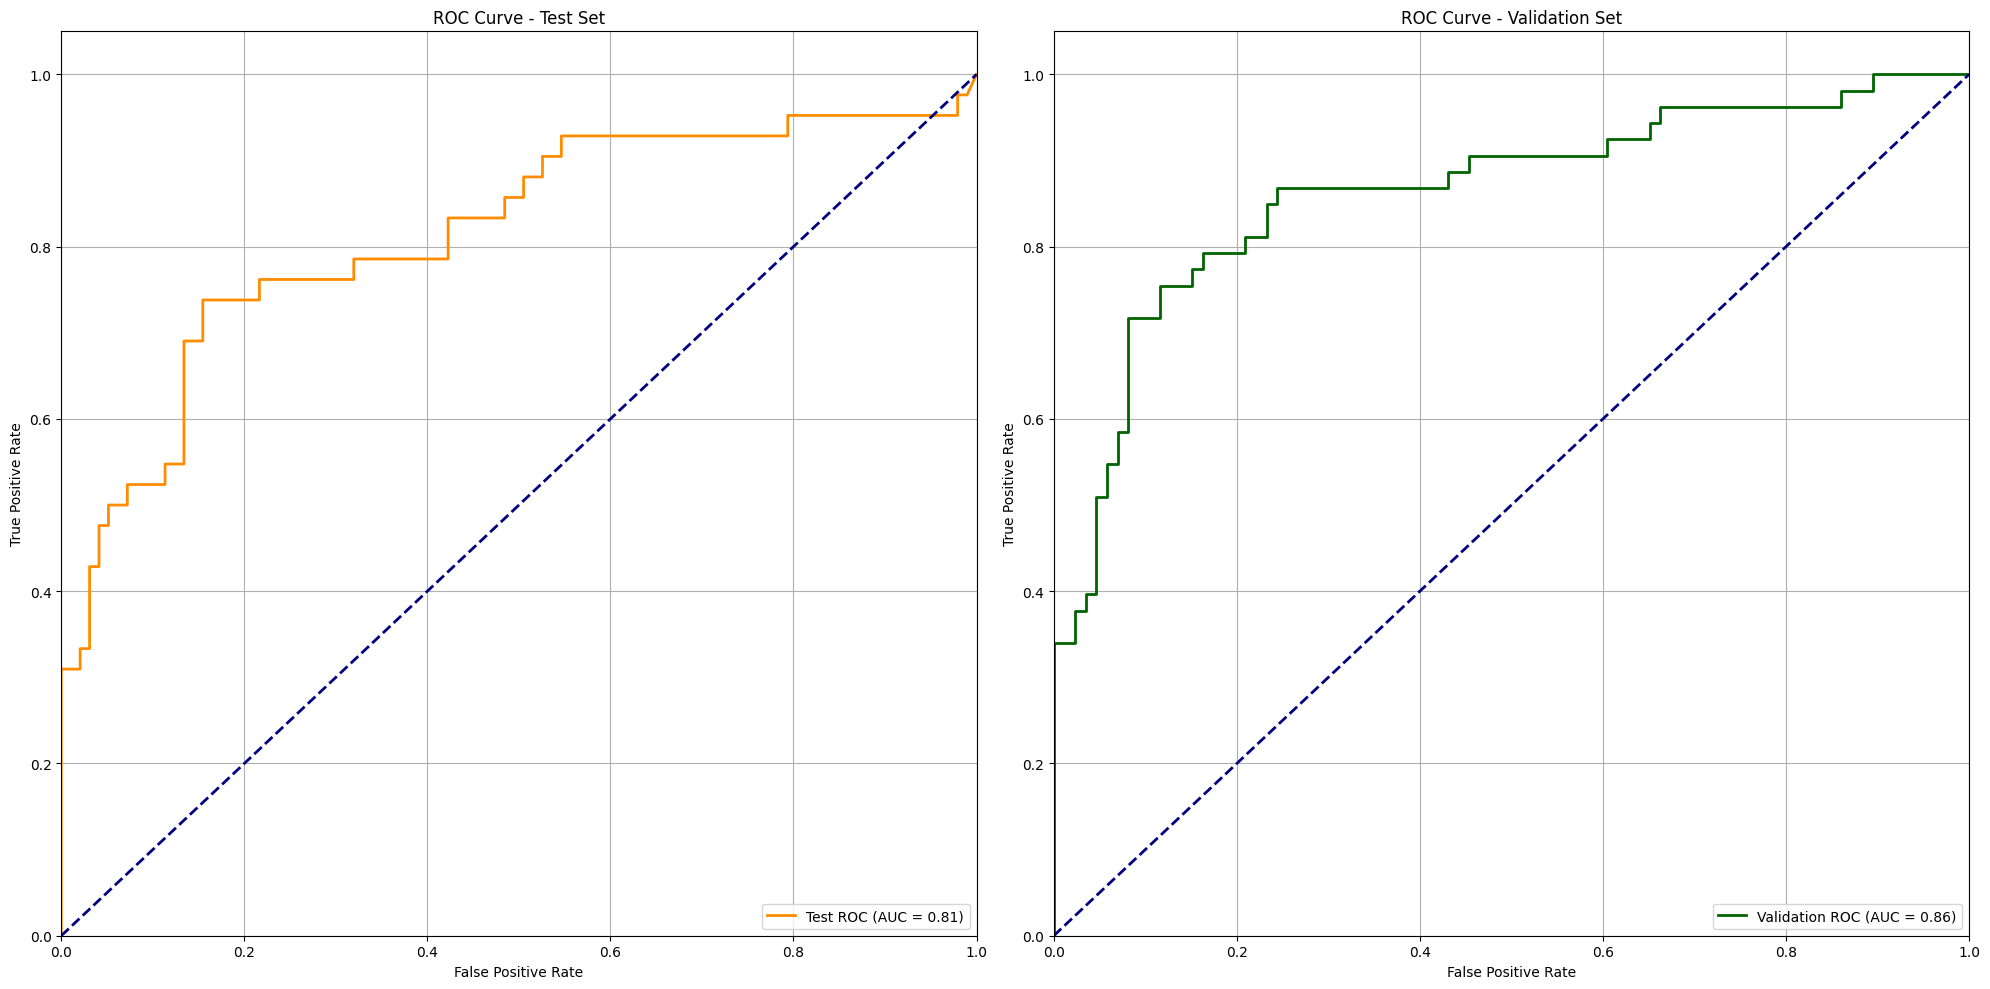

In [127]:
fpr_test, tpr_test, _ = roc_curve(y_test, stacking_model_2.predict_proba(X_test)[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)

fpr_val, tpr_val, _ = roc_curve(y_val, stacking_model_2.predict_proba(X_val)[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(fpr_test, tpr_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {roc_auc_test:.2f})')
axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[0].set_xlim([0.0, 1.0])
axs[0].set_ylim([0.0, 1.05])
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].set_title('ROC Curve - Test Set')
axs[0].legend(loc='lower right')
axs[0].grid(True)

axs[1].plot(fpr_val, tpr_val, color='darkgreen', lw=2, label=f'Validation ROC (AUC = {roc_auc_val:.2f})')
axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axs[1].set_xlim([0.0, 1.0])
axs[1].set_ylim([0.0, 1.05])
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve - Validation Set')
axs[1].legend(loc='lower right')
axs[1].grid(True)

plt.tight_layout()
plt.show()

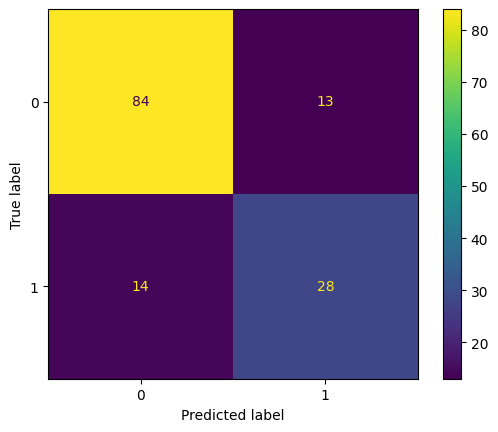

In [115]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()